In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arif-ref-gig/clean_fake_news_dataset.csv
/kaggle/input/arif-ref-gig/True.csv
/kaggle/input/arif-ref-gig/Fake.csv
/kaggle/input/arif-ref-gig/glove.6B.100d.txt
/kaggle/input/arif-ref-gig/comb_true_fake.csv
/kaggle/input/arif-ref-gig/fake_news_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import random

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Set the random seed
seed_value = 42
random.seed(seed_value)

In [4]:
df = pd.read_csv('/kaggle/input/arif-ref-gig/comb_true_fake.csv', index_col=0)
df1 = pd.read_csv('/kaggle/input/arif-ref-gig/clean_fake_news_dataset.csv', index_col=0)

In [5]:
df.head()

,title,text,class
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,0


In [6]:
df1.head()

,label,class,news
0,False,1,Says the Annies List political group supports ...
1,True,0,When did the decline of coal start? It started...
2,True,0,"Hillary Clinton agrees with John McCain ""by vo..."
3,False,1,Health care reform legislation is likely to ma...
4,True,0,The economic turnaround started at the end of ...


Now to combine the title and text column to form one variable column that'll be fed into the model

In [7]:
# Create new text column which includes title
df_model = df.copy()
df_model['text'] = df_model['text'] + " " + df_model['title']

# Drop unwanted columns
df_model = df_model.drop('title', axis = 1)

# Check
df_model.head()

,text,class
0,"Donald Trump s White House is in chaos, and th...",0
1,Now that Donald Trump is the presumptive GOP n...,0
2,Mike Pence is a huge homophobe. He supports ex...,0
3,SAN FRANCISCO (Reuters) - California Attorney ...,1
4,Twisted reasoning is all that comes from Pelos...,0


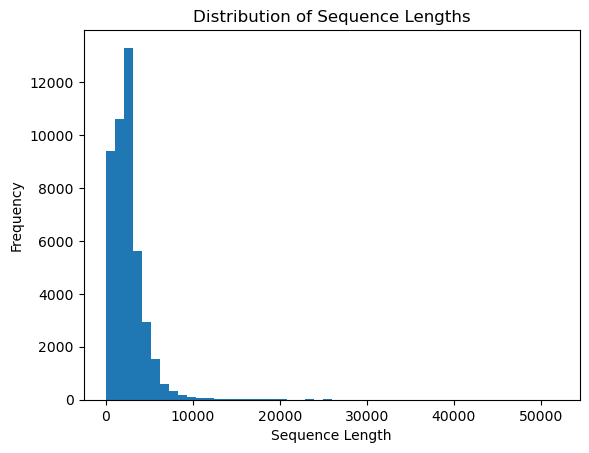

In [8]:
# Calculate the sequence lengths
sequence_lengths = [len(seq) for seq in df_model['text']]

# Plot a histogram
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [9]:
from collections import Counter

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

import string 

from wordcloud import WordCloud,STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


We will use BeautifulSoup to remove urls and create a function that does so for reusability.

In [10]:
# Define function to remove html
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleantext = soup.get_text()
    return cleantext

In [11]:
# Apply function
df_clean = df_model.copy()
df_clean['text'] = df_clean['text'].apply(remove_html)


/tmp/ipykernel_28/3548029525.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [12]:
# Preview first entry
df_clean['text'][0][:1000]

'Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of this. To them, it s  fake news,  or a  hoax.  However, the facts bear things out differently, and it seems that there are now cracks in the Congressional public leadership.Chuck Grassley (R-Iowa), who heads the Senate Judiciary Committee, is fed up. He is now demanding that Donald Trump, Jr. and former 2016 Trump Campaign Manager Paul Manafort testify before his committee regarding the now infamous shady meeting between Donald Trump and the shady Russian lawyer who promised dirt on 2016 Democratic Presidential nominee Hillary Clinton. In fact, this information is due, well, NOW. This demand sends a few signals to team Trump   most notably that they should not fire Special Counsel Robert Mueller under any circumstances, despite the fact that it seems that this seems to be what Trump s White 

We will look to remove stopwords.

In [13]:
# Define stopwords
stop = set(stopwords.words('english'))

We will create a function which returns the text without stopwords.

In [14]:
# Define function to remove stopwords
def remove_stopwords(text):
    words = []
    for word in text.split():
        if word.strip().lower() not in stop:
            words.append(word.strip())
    cleantext = " ".join(words)
    return cleantext

In [15]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_stopwords)

In [16]:
# Preview first entry
df_clean['text'][0][:1000]

'Donald Trump White House chaos, trying cover up. Russia problems mounting hour, refuse acknowledge problems surrounding this. them, fake news, hoax. However, facts bear things differently, seems cracks Congressional public leadership.Chuck Grassley (R-Iowa), heads Senate Judiciary Committee, fed up. demanding Donald Trump, Jr. former 2016 Trump Campaign Manager Paul Manafort testify committee regarding infamous shady meeting Donald Trump shady Russian lawyer promised dirt 2016 Democratic Presidential nominee Hillary Clinton. fact, information due, well, NOW. demand sends signals team Trump notably fire Special Counsel Robert Mueller circumstances, despite fact seems seems Trump White House laying groundwork, speak, speak.Here tweet regarding Grassley warning:Also, anyone thinks Senator Grassley rest Senate serious needs look warning already given: Trump Jr. Manafort either follow orders, served subpoenas force comply. refuse, held contempt Congress, carries serious jail time.Even crue

**Next we will remove punctuation**

In [17]:
# Define punctuation
punctuation = list(string.punctuation)
punctuation.append("“")
punctuation.append("”")
punctuation.append("’")

In [18]:
# Define function to remove punctuation
def remove_punctuation(text):
    no_punct = ""
    for char in text:
        if char not in punctuation:
            no_punct += char
    return no_punct

In [19]:
# Apply function to text
df_clean['text'] = df_clean['text'].apply(remove_punctuation)


In [20]:
# Preview first entry
df_clean['text'][0][:1000]

'Donald Trump White House chaos trying cover up Russia problems mounting hour refuse acknowledge problems surrounding this them fake news hoax However facts bear things differently seems cracks Congressional public leadershipChuck Grassley RIowa heads Senate Judiciary Committee fed up demanding Donald Trump Jr former 2016 Trump Campaign Manager Paul Manafort testify committee regarding infamous shady meeting Donald Trump shady Russian lawyer promised dirt 2016 Democratic Presidential nominee Hillary Clinton fact information due well NOW demand sends signals team Trump notably fire Special Counsel Robert Mueller circumstances despite fact seems seems Trump White House laying groundwork speak speakHere tweet regarding Grassley warningAlso anyone thinks Senator Grassley rest Senate serious needs look warning already given Trump Jr Manafort either follow orders served subpoenas force comply refuse held contempt Congress carries serious jail timeEven cruel craven creatures within GOP sick D

## Modelling

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [22]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# setting some variables

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


# Tokenize the text column
tokenizer_text = Tokenizer(num_words = 10000, oov_token=oov_tok)
tokenizer_text.fit_on_texts(train_df['text'])
word_index_text = tokenizer_text.word_index

# Convert text to sequences for the text column
train_sequences_text = tokenizer_text.texts_to_sequences(train_df['text'])
test_sequences_text = tokenizer_text.texts_to_sequences(test_df['text'])

# Pad sequences for the text column
# max_sequence_length_text = 10000  # Specify the maximum length of the sequences for the text column
train_data_text = pad_sequences(train_sequences_text, maxlen=300, padding=padding_type, truncating=trunc_type)
test_data_text = pad_sequences(test_sequences_text, maxlen=300, padding=padding_type, truncating=trunc_type)

# Prepare the target variable
train_labels = train_df['class'].values
test_labels = test_df['class'].values

In [23]:
embedding_file = '/kaggle/input/arif-ref-gig/glove.6B.100d.txt'

with open(embedding_file, 'r', encoding='utf-8') as file:
    first_line = file.readline()
    embedding_dimension = len(first_line.split()) - 1

print("Embedding Dimension:", embedding_dimension)

Embedding Dimension: 100


In [24]:
# Load GloVe word embeddings
glove_file = '/kaggle/input/arif-ref-gig/glove.6B.100d.txt'  # Specify the path to your GloVe embedding file
embedding_dim = 100  # Specify the dimensionality of the GloVe embeddings

# Create embedding matrix for text column
embedding_matrix_text = np.zeros((len(word_index_text) + 1, embedding_dim))
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index_text:
            embedding_matrix_text[word_index_text[word]] = np.array(values[1:], dtype='float32')


In [25]:
len(word_index_text) + 1

208638

In [26]:
# Build the model
# model = Sequential()
# model.add(Embedding(len(word_index_text) + 1, embedding_dim, embeddings_initializer=Constant(embedding_matrix_text),
#                    input_length=max_sequence_length_text, trainable=False))
# model.add(LSTM(units=128,
#              return_sequences = True))

# model.add(LSTM(units = 64))

# model.add(Dense(units = 42, activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))


# Define model
model = Sequential()

# Add embedding layer (non-trainable)
model.add(Embedding(len(word_index_text) + 1, 
                    output_dim = 100,
                    weights = [embedding_matrix_text],
                    input_length = 300,
                    trainable = False))

# Add other layers
model.add(LSTM(units = 128,
               return_sequences = True, 
               recurrent_dropout = 0.25,
               dropout = 0.25))

model.add(LSTM(units = 64,
               recurrent_dropout = 0.1,
               dropout = 0.1))

model.add(Dense(units = 42, activation = 'relu'))

model.add(Dense(units = 1, activation = 'sigmoid'))
# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

 # Get summary
model.summary()         

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          20863800  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 42)                2730      
                                                                 
 dense_1 (Dense)             (None, 1)                 43        
                                                                 
Total params: 21,033,229
Trainable params: 169,429
Non-trainable params: 20,863,800
_________________________________________________________________


In [27]:
# Fit model
history = model.fit(train_data_text, 
                    train_labels, 
                    batch_size = 64 , 
                    validation_data = (test_data_text, test_labels) , 
                    epochs = 10)

Epoch 1/10
562/562 [==============================] - 1469s 3s/step - loss: 0.6443 - accuracy: 0.6162 - val_loss: 0.5931 - val_accuracy: 0.6904
Epoch 2/10
562/562 [==============================] - 1446s 3s/step - loss: 0.5809 - accuracy: 0.6911 - val_loss: 0.4648 - val_accuracy: 0.8124
Epoch 3/10
562/562 [==============================] - 1418s 3s/step - loss: 0.2960 - accuracy: 0.8597 - val_loss: 0.0265 - val_accuracy: 0.9938
Epoch 4/10
562/562 [==============================] - 1436s 3s/step - loss: 0.0203 - accuracy: 0.9956 - val_loss: 0.0353 - val_accuracy: 0.9930
Epoch 5/10
562/562 [==============================] - 1430s 3s/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.0167 - val_accuracy: 0.9961
Epoch 6/10
562/562 [==============================] - 1430s 3s/step - loss: 0.0401 - accuracy: 0.9862 - val_loss: 0.0243 - val_accuracy: 0.9928
Epoch 7/10
562/562 [==============================] - 1429s 3s/step - loss: 0.0213 - accuracy: 0.9939 - val_loss: 0.0174 - val_accuracy:

In [29]:
loss, accuracy = model.evaluate(test_data_text, test_labels)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

281/281 [==============================] - 48s 172ms/step - loss: 0.0127 - accuracy: 0.9972
Test Loss: 0.0127
Test Accuracy: 0.9972
